# Ice Optics Parameterization Comparison (v1a)

## Setting up LUT

Here, we are creating look-up-tables (LUT) for optical properties such as extinction coefficients, single scatter albedo $\omega_0$ and assymetry parameter $g$ for ice cloud parameter ranges used in Test 1 (Altitude/Temperature):

* Ice Mass Mixing ratio $q_i$ $\left[\frac{\text{kg of ice}}{\text{kg of air}}\right]$ range: 

$$q_i = \left(\text{0.04 to 0.11} \; \left[\frac{\text{g of ice}}{\text{kg of air}}\right]\right) \; \times \; 0.001 \; \left[\frac{\text{kg of ice}}{\text{g of ice}}\right]$$

* Ice Water Content IWC ($g$ $m^{-3}$) (We're using an average density of 0.3 $kg$ $m^{-3}$ between 10 km and 15 km):

$$IWC = q_i \left[\frac{\text{kg of ice}}{\text{kg of air}}\right] * 1000 \left[\frac{\text{g of ice}}{\text{kg of ice}}\right] * 0.3 \left[\frac{\text{kg of air}}{m^3}\right]$$

* Ice Water Path IWP ($g/m^2$) range: 0.1 to 300.1 $g/m^2$

* Fixed Effective Radius $r_e (\mu m)$ (not needed for this case)

* Temperature T (K) range: 190 to 260.5 

In [2]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import math
import pandas as pd
from scipy import interpolate

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator

%matplotlib notebook

# Baran et al. 2016

In [3]:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_rad_data_backup/')
file      = 'baran2016_ice_scattering_rrtm.nc'
baran16   = xr.open_dataset(data_path+file)

In [4]:
baran16

<xarray.Dataset>
Dimensions:         (band_lw: 16, band_sw: 14, coeff: 5)
Dimensions without coordinates: band_lw, band_sw, coeff
Data variables:
    wavenumber1_lw  (band_lw) float32 ...
    wavenumber2_lw  (band_lw) float32 ...
    wavenumber1_sw  (band_sw) float32 ...
    wavenumber2_sw  (band_sw) float32 ...
    coeff_lw        (band_lw, coeff) float32 ...
    coeff_sw        (band_sw, coeff) float32 ...
Attributes:
    comment:  This file provides a parameterization of ice particle scatterin...

In [5]:
# SHORTWAVE
# Lower bound wavenumber (cm-1) for shortwave band.
baran16_sw_wn1 = baran16.variables['wavenumber1_sw'][:]
baran16_sw_wl1 = 1e4 / baran16_sw_wn1 # (um)

# Upper bound wavenumber (cm-1) for shortwave band.
baran16_sw_wn2 = baran16.variables['wavenumber2_sw'][:]
baran16_sw_wl2 = 1e4 / baran16_sw_wn2 # (um)

# Shortwave Coefficients (10 coefficients in total):
baran16_sw_coeff = baran16.variables['coeff_sw'][:]



# LONGWAVE
# Lower bound wavenumber (cm-1) for longwave band.
baran16_lw_wn1 = baran16.variables['wavenumber1_lw'][:]
baran16_lw_wl1 = 1e4/baran16_lw_wn1 # (um)

# Upper bound wavenumber (cm-1) for longwave band. See Tables
baran16_lw_wn2 = baran16.variables['wavenumber2_lw'][:]
baran16_lw_wl2 = 1e4 / baran16_lw_wn2 # (um)

# Longwave Coefficients:
baran16_lw_coeff = baran16.variables['coeff_lw'][:]

In [6]:
# Pandas DataFrame for visualization:

# SW:
baran16_sw_band_lim    = []
baran16_sw_band_lim_cm = []
for wl in range(len(baran16_sw_wl1)):
    wl2_str = str(round(float(baran16_sw_wl2[wl]),3))
    wl1_str = str(round(float(baran16_sw_wl1[wl]),3))
    wn2_str = str(int(baran16_sw_wn2[wl]))
    wn1_str = str(int(baran16_sw_wn1[wl]))
    baran16_sw_band_lim.append(wl2_str + ' - ' + wl1_str)
    baran16_sw_band_lim_cm.append(wn1_str + ' - ' + wn2_str)
baran16_sw_tables = pd.DataFrame({'Band limits (um)': baran16_sw_band_lim,
                                  'Band limits (cm-1)': baran16_sw_band_lim_cm,
                                  'a': baran16_sw_coeff[:,0],
                                  'b': baran16_sw_coeff[:,1],
                                  'c': baran16_sw_coeff[:,2],
                                  'd': baran16_sw_coeff[:,3],
                                  'e': baran16_sw_coeff[:,4]
                                 })
baran16_sw_tables = baran16_sw_tables.set_index('Band limits (um)')

# LW:
baran16_lw_band_lim = []
baran16_lw_band_lim_cm = []
for wn in range(len(baran16_lw_wn1)):
    wl2_str = str(round(float(baran16_lw_wl2[wn]),3))
    wl1_str = str(round(float(baran16_lw_wl1[wn]),3))
    wn2_str = str(int(baran16_lw_wn2[wn]))
    wn1_str = str(int(baran16_lw_wn1[wn]))
    baran16_lw_band_lim.append(wl2_str + ' - ' + wl1_str)
    baran16_lw_band_lim_cm.append(wn1_str + ' - ' + wn2_str)
baran16_lw_tables = pd.DataFrame({'Band limits (um)': baran16_lw_band_lim,
                                  'Band limits (cm-1)': baran16_lw_band_lim_cm,
                                  'a': baran16_lw_coeff[:,0],
                                  'b': baran16_lw_coeff[:,1],
                                  'c': baran16_lw_coeff[:,2],
                                  'd': baran16_lw_coeff[:,3],
                                  'e': baran16_lw_coeff[:,4]
                                 })
baran16_lw_tables = baran16_lw_tables.set_index('Band limits (um)')

## Baran et al. 2016 - Shortwave

In [7]:
pd.options.display.float_format = '{:.6e}'.format
#pd.reset_option('format')
#fu_sw_tables.style.format({'a0': '{:10.6e}'})
baran16_sw_tables

,Band limits (cm-1),a,b,c,d,e
Band limits (um),,,,,,
3.077 - 3.846,2600 - 3250,1.600000e+11,7.500000e-01,-2.353000e-01,9.130000e-01,1.240000e-01
2.5 - 3.077,3250 - 4000,1.600000e+11,7.500000e-01,-2.353000e-01,9.130000e-01,1.240000e-01
2.151 - 2.5,4000 - 4650,1.650000e+11,9.817000e-01,-4.218000e-01,8.208000e-01,1.351000e-01
1.942 - 2.151,4650 - 5150,1.650000e+11,9.817000e-01,-4.218000e-01,8.208000e-01,1.351000e-01
1.626 - 1.942,5150 - 6150,1.650000e+11,9.817000e-01,-4.218000e-01,8.208000e-01,1.351000e-01
1.299 - 1.626,6150 - 7700,1.650000e+11,9.817000e-01,-4.218000e-01,8.208000e-01,1.351000e-01
1.242 - 1.299,7700 - 8050,1.650000e+11,9.817000e-01,-4.218000e-01,8.208000e-01,1.351000e-01
0.778 - 1.242,8050 - 12850,1.640000e+11,9.996000e-01,-3.100000e-03,7.897000e-01,4.680000e-02
0.625 - 0.778,12850 - 16000,1.640000e+11,9.996000e-01,-3.100000e-03,7.897000e-01,4.680000e-02


In [8]:
# Ice Mass Mixing ratio qi (kg/kg):
q_i = np.arange(0.04, 0.11, 0.001) * 0.001 # Range used in Test 1 - Altitude/Temperature.

# Ice Water Content IWC (g/m3) (We use an average density of 0.3 kg m-3 between 10 km and 15 km):
iwc = q_i * 1000 * 0.3

# Ice Water Path IWP (g/m2):
#iwp = np.arange(0.1, 300.1, 0.1)

# Effective Radius r_e (um) not needed for this case

# Effective Diameter D_e (um) not needed for this case

# Temperature
T = np.arange(190, 260.5, .5) # Temperature (K)

# SHORTWAVE:

# Extinction Coefficient Beta_ext (1/m)
baran16_sw_b_ext = np.zeros((len(baran16_sw_wn1), len(T), len(q_i)))
# Mass Extinction Coefficient K_ext (m2/kg)
baran16_sw_K_ext = np.zeros((len(baran16_sw_wn1), len(T), len(q_i)))
# Mass Absorption Coefficient K_abs (m2/kg)
baran16_sw_K_abs = np.zeros((len(baran16_sw_wn1), len(T), len(q_i)))
# Optical Depth OD (Following Hogan equations in "radiation_ice_optics_baran.F90"):
baran16_sw_od    = np.zeros((len(baran16_sw_wn1), len(T), len(q_i)))

# Single Scatter Albedo:
baran16_sw_ssa     = np.zeros((len(baran16_sw_wn1), len(T), len(q_i)))
# Scattering Optical Depth (Following Hogan equations in "radiation_ice_optics_baran.F90"):
baran16_sw_scat_od = np.zeros((len(baran16_sw_wn1), len(T), len(q_i)))

# Asymmetry Factor:
baran16_sw_g = np.zeros((len(baran16_sw_wn1), len(T), len(q_i)))

for wn_ix in range(len(baran16_sw_wn1)):
    a = baran16.coeff_sw.values[wn_ix, 0] # Coefficient a
    b = baran16.coeff_sw.values[wn_ix, 1] # Coefficient b    
    c = baran16.coeff_sw.values[wn_ix, 2] # Coefficient c
    d = baran16.coeff_sw.values[wn_ix, 3] # Coefficient d
    e = baran16.coeff_sw.values[wn_ix, 4] # Coefficient e
    for T_ix in range(len(T)):
        T_i = T[T_ix]
        for q_i_ix in range(len(q_i)):
            q_i_i = q_i[q_i_ix]
            
            # Mass Extinction Coefficient Kext (transformed to m2/g). 
                # See eq. (2) in Baran et al. 2016:
            #K_ext_i = 0.001 * (a * (q_i_i / (T_i ** 4)))
                # From Hogan's Fortran code. Why this is not including ice mixing ratio?
            K_ext_i = 0.001 * a * (1 / (T_i ** 4)) 
            baran16_sw_K_ext[wn_ix, T_ix, q_i_ix] = K_ext_i
            
            # See eq. (3) in Baran et al. 2016:
            ssa_i = b + c * q_i_i * T_i
            baran16_sw_ssa[wn_ix, T_ix, q_i_ix] = ssa_i
            
            # Mass Absorption Coefficient Kabs:
            K_abs_i = K_ext_i * (1 - ssa_i)
            baran16_sw_K_abs[wn_ix, T_ix, q_i_ix] = K_abs_i
            
            # Asymmetry Parameter g. See eq. (4) in Baran et al. 2016:
            g_i = d + e*q_i_i*T_i
            baran16_sw_g[wn_ix, T_ix, q_i_ix] = g_i

### Saving 3d tables for Ke, Ka, w and g for Baran2016 SW

In [9]:
baran16_sw = xr.Dataset(
    data_vars = dict(
        K_ext = (['sw_wn_1', 'T', 'iwc'], baran16_sw_K_ext),
        K_abs = (['sw_wn_1', 'T', 'iwc'], baran16_sw_K_abs),
        ssa = (['sw_wn_1', 'T', 'iwc'], baran16_sw_ssa),
        g = (['sw_wn_1', 'T', 'iwc'], baran16_sw_g),
    ),
    attrs = dict(
        title="LUT for Baran2016 SW. Ranges for Altitude-Temperature Test."),
)

In [10]:
out_dir = ('/groups/sylvia/ecrad_tests/LUT_SchComp/')
file    = 'Baran16SW_test1_LUT_v1a.nc'
baran16_sw.to_netcdf(path = out_dir+file)

## Baran et al. 2016 - Longwave

In [10]:
pd.options.display.float_format = '{:.6e}'.format
#pd.reset_option('format')
#fu_sw_tables.style.format({'a0': '{:10.6e}'})
baran16_lw_tables

,Band limits (cm-1),a,b,c,d,e
Band limits (um),,,,,,
28.571 - 1000.0,10 - 350,1.500000e+11,6.300000e-01,-2.500000e-01,7.129000e-01,6.568000e-01
20.0 - 28.571,350 - 500,1.750000e+11,7.700000e-01,-2.866000e-01,8.356000e-01,3.085000e-01
15.873 - 20.0,500 - 630,1.730000e+11,5.480000e-01,1.080000e-02,8.843000e-01,1.833000e-01
14.286 - 15.873,630 - 700,1.740000e+11,5.469000e-01,1.460000e-02,8.845000e-01,1.730000e-01
12.195 - 14.286,700 - 820,1.730000e+11,5.480000e-01,1.080000e-02,8.843000e-01,1.833000e-01
10.204 - 12.195,820 - 980,1.440000e+11,5.346000e-01,1.060000e-02,9.338000e-01,1.013000e-01
9.259 - 10.204,980 - 1080,1.540000e+11,6.500000e-01,-1.420000e-01,9.401000e-01,1.144000e-01
8.475 - 9.259,1080 - 1180,1.540000e+11,6.500000e-01,-1.420000e-01,9.401000e-01,1.144000e-01
7.194 - 8.475,1180 - 1390,1.700000e+11,6.000000e-01,-1.781000e-01,9.264000e-01,1.513000e-01


In [11]:
# Ice Mass Mixing ratio qi (kg/kg):
q_i = np.arange(0.04, 0.11, 0.001) * 0.001 # Range used in Test 1 - Altitude/Temperature.

# Ice Water Content IWC (g/m3) (We use an average density of 0.3 kg m-3 between 10 km and 15 km):
iwc = q_i * 1000 * 0.3

# Ice Water Path IWP (g/m2):
#iwp = np.arange(0.1, 300.1, 0.1)

# Effective Radius r_e (um) not needed for this case

# Effective Diameter D_e (um) not needed for this case

# Temperature
T   = np.arange(190, 260.5, .5) # Temperature (K)

# LONGWAVE:

# Extinction Coefficient B_ext (1/m)
baran16_lw_b_ext = np.zeros((len(baran16_lw_wn1), len(T), len(q_i)))
# Mass Extinction Coefficient K_ext (m2/kg)
baran16_lw_K_ext = np.zeros((len(baran16_lw_wn1), len(T), len(q_i)))
# Mass Absorption Coefficient K_abs (m2/kg)
baran16_lw_K_abs = np.zeros((len(baran16_lw_wn1), len(T), len(q_i)))
# Optical Depth OD (Following Hogan equations in "radiation_ice_optics_baran.F90"):
baran16_lw_od    = np.zeros((len(baran16_lw_wn1), len(T), len(q_i)))

# Single Scatter Albedo:
baran16_lw_ssa     = np.zeros((len(baran16_lw_wn1), len(T), len(q_i)))
# Scattering Optical Depth (Following Hogan equations in "radiation_ice_optics_baran.F90"):
baran16_lw_scat_od = np.zeros((len(baran16_lw_wn1), len(T), len(q_i)))

# Asymmetry Factor:
baran16_lw_g = np.zeros((len(baran16_lw_wn1), len(T), len(q_i)))

for wn_ix in range(len(baran16_lw_wn1)):
    a = baran16.coeff_lw.values[wn_ix, 0] # Coefficient a
    b = baran16.coeff_lw.values[wn_ix, 1] # Coefficient b    
    c = baran16.coeff_lw.values[wn_ix, 2] # Coefficient c
    d = baran16.coeff_lw.values[wn_ix, 3] # Coefficient d
    e = baran16.coeff_lw.values[wn_ix, 4] # Coefficient e
    for T_ix in range(len(T)):
        T_i = T[T_ix]
        for q_i_ix in range(len(q_i)):
            q_i_i = q_i[q_i_ix]

            # Mass Extinction Coefficient Kext (transformed to m2/g). 
                # See eq. (2) in Baran et al. 2016:
            #K_ext_i = 0.001 * (a * (q_i_i / (T_i ** 4)))
            # From Hogan's Fortran code. Why this is not including ice mixing ratio?
            K_ext_i = 0.001 * a * (1 / (T_i ** 4))
            baran16_lw_K_ext[wn_ix, T_ix, q_i_ix] = K_ext_i
            
            # See eq. (3) in Baran et al. 2016:
            ssa_i = b + c * q_i_i * T_i
            baran16_lw_ssa[wn_ix, T_ix, q_i_ix] = ssa_i
            
            # Mass Absorption Coefficient Kabs:
            K_abs_i = K_ext_i * (1 - ssa_i)
            baran16_lw_K_abs[wn_ix, T_ix, q_i_ix] = K_abs_i
            
            # Asymmetry Parameter g. See eq. (4) in Baran et al. 2016:
            g_i = d + e*q_i_i*T_i
            baran16_lw_g[wn_ix, T_ix, q_i_ix] = g_i

Extinction coefficient not depending on ice mixing ratio? Just Temperature?

### Saving 3d tables for Ke, Ka, w and g for Baran2016 LW

In [12]:
baran16_lw = xr.Dataset(
    data_vars = dict(
        K_ext = (['sw_wn_1', 'T', 'iwc'], baran16_lw_K_ext),
        K_abs = (['sw_wn_1', 'T', 'iwc'], baran16_lw_K_abs),
        ssa = (['sw_wn_1', 'T', 'iwc'], baran16_lw_ssa),
        g = (['sw_wn_1', 'T', 'iwc'], baran16_lw_g),
    ),
    attrs = dict(
        title="LUT for Baran2016 LW. Ranges for Altitude-Temperature Test."),
)

In [16]:
out_dir = ('/groups/sylvia/ecrad_tests/LUT_SchComp/')
file    = 'Baran16LW_test1_LUT_v1a.nc'
baran16_lw.to_netcdf(path = out_dir+file)

## Plotting Baran16 Optical parameters vs Wavelength and IWC

ALL BANDS

<IPython.core.display.Javascript object>


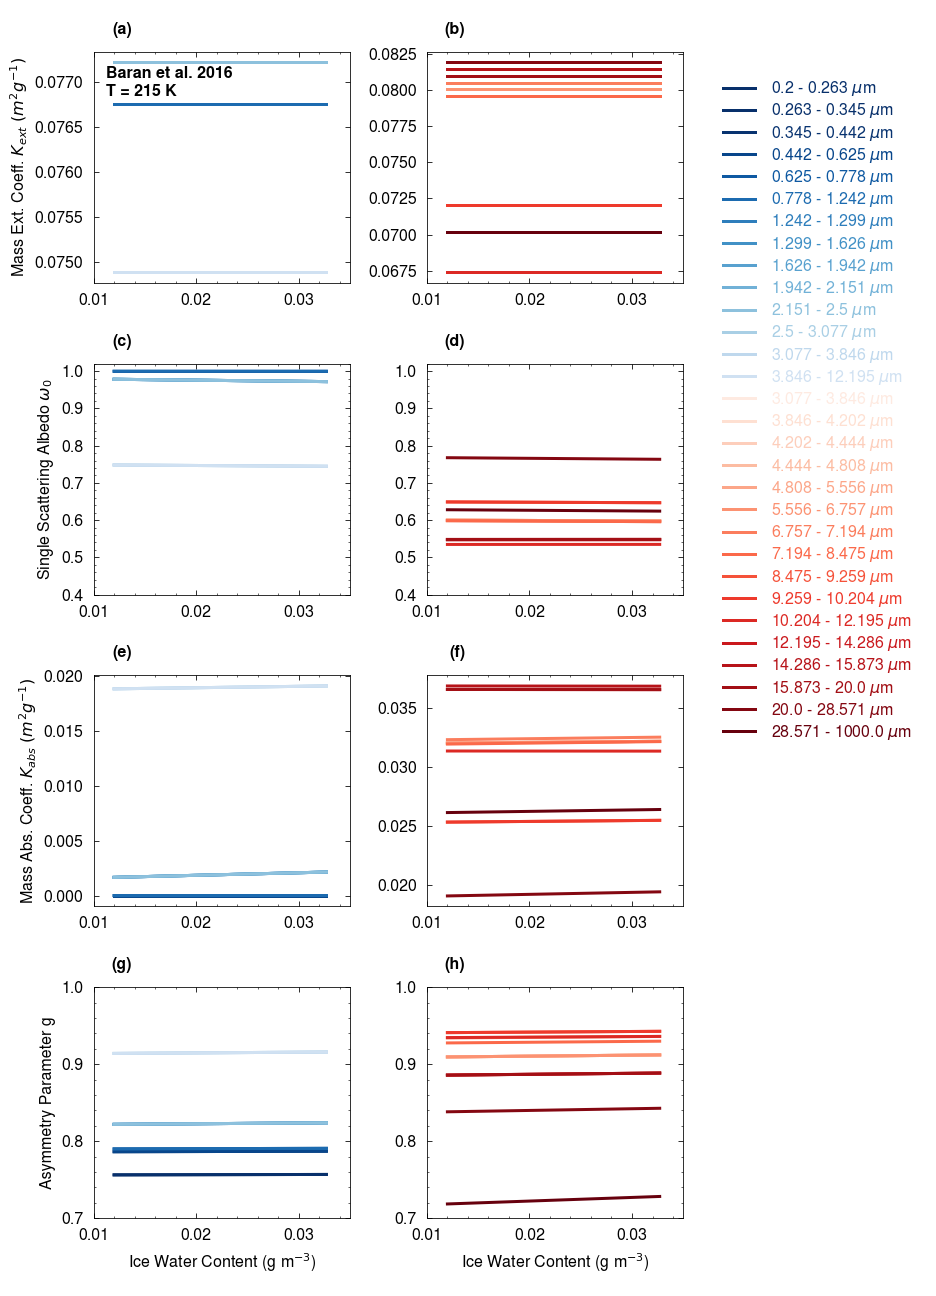

In [15]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 18 # inches
flength  = 13 # inches


rows    = 4
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.96, bottom = 0.06, left = 0.1, right = 0.73, 
                    hspace = .35, wspace = .3)


rad_comps       = ['sw', 'lw']
opt_props       = ['K_ext', 'ssa', 'K_abs', 'g']
opt_props_label = [r'Mass Ext. Coeff. $K_{ext}$ $(m^2g^{-1})$', r'Single Scattering Albedo $\omega_0$', 
                   r'Mass Abs. Coeff. $K_{abs}$ $(m^2g^{-1})$', 'Asymmetry Parameter g']
panel_letters   = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
panel_letters_i = 0

sel_temp  = 215
sel_tempi = np.where(T == sel_temp)[0][0] # 215 K selected ("middle" range)

for opt_prop in range(rows):
    handles = []
    labels  = []
    for rad_comp in range(columns):
        baran16_plot = eval('baran16_'+rad_comps[rad_comp]+'_'+opt_props[opt_prop])
        if rad_comp == 0: bands = list(np.arange(0,13)[::-1]) + [13]
        if rad_comp == 1: bands = list(np.arange(0,16)[::-1])
        for band in bands:
            if rad_comp == 0: color = matplotlib.cm.Blues(.9 - (len(bands)-bands[::-1].index(band))/len(bands) + .3)
            if rad_comp == 1: color = matplotlib.cm.Reds(.1 + (len(bands)-bands[::-1].index(band))/len(bands) - .1)
            h = ax[opt_prop, rad_comp].plot(iwc, baran16_plot[band, sel_tempi, :],
                                            linestyle = 'solid', 
                                            linewidth = 3, color = color)
            handles = handles + h
            #if rad_comp == 0:
            label = (str(round(float(1e4/eval('baran16_'+rad_comps[rad_comp]+'_wn2')[band]),3)) + ' - ' +  
                     str(round(float(1e4/eval('baran16_'+rad_comps[rad_comp]+'_wn1')[band]),3)) + r' $\mu$m')
#             if rad_comp == 1:
#                 label = (str(int(eval('baran16_'+rad_comps[rad_comp]+'_wn1')[band])) + ' - ' +  
#                          str(int(eval('baran16_'+rad_comps[rad_comp]+'_wn2')[band])) + r' $cm^{-1}$')    
            labels.append(label)

        # X Axis:
        if opt_prop == 3:
            ax[opt_prop, rad_comp].set_xlabel(r'Ice Water Content (g m$^{-3}$)', 
                                              fontsize = fontsize, fontname = fontname,
                                              color ='black', labelpad = 7.5)
        ax[opt_prop, rad_comp].set_xlim(0.01, 0.035)
        ax[opt_prop, rad_comp].xaxis.set_major_locator(ticker.MultipleLocator(0.01))
        ax[opt_prop, rad_comp].xaxis.set_minor_locator(ticker.MultipleLocator(0.002))
        ax[opt_prop, rad_comp].tick_params(axis = 'x', which = 'major', color = 'black',
                                           size = 4, direction = 'in', top = True,
                                           labelsize = fontsize, pad = 10)
        for tick in ax[opt_prop, rad_comp].get_xticklabels():
            tick.set_fontname(fontname)
        
        ax[opt_prop, rad_comp].tick_params(axis = 'y', which = 'major', color = 'black',
                                           size = 4, direction = 'in', right = True,
                                           labelsize = fontsize, pad = 10)
        for tick in ax[opt_prop, rad_comp].get_yticklabels():
            tick.set_fontname(fontname)
 
        # Y Axis:
        opt_props_labeli = opt_props_label[opt_prop]
        if rad_comp == 0:
            ax[opt_prop, rad_comp].set_ylabel(opt_props_labeli, fontsize = fontsize, 
                                              fontname = fontname, color ='black', labelpad = 5) 
        if opt_prop == 0: # Mass Extinction Coefficient
            test = True
            #ax[opt_prop, rad_comp].set_ylim(3e-6, 1.3e-5)
            #ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(2e-6))
            #ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.5e-6))
        elif opt_prop == 1: # SSA
            ax[opt_prop, rad_comp].set_ylim(0.4, 1.02)
            ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.1))
            ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
        elif opt_prop == 2: # Mass Absoprtion Coefficient
            test = True
            #ax[opt_prop, rad_comp].set_ylim(3e-6, 1.3e-5)
            #ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(2e-6))
            #ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.5e-6))
        elif opt_prop == 3: # g
            ax[opt_prop, rad_comp].set_ylim(0.7, 1)
            ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.1))
            ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
        for tick in ax[opt_prop, rad_comp].get_yticklabels():
            tick.set_fontname(fontname)
            
        # Both axis:
        ax[opt_prop, rad_comp].tick_params(axis = 'both', which = 'major', color = 'black',
                                           size = 5, direction = 'in', top = True, right = True,
                                           labelsize = fontsize, pad = 10)
        ax[opt_prop, rad_comp].tick_params(axis = 'both', which = 'minor', color = 'black', 
                                           size = 2, direction = 'in', top = True, right = True,
                                           labelsize = fontsize, pad = 10)
            
        # Panel letters:
        ax[opt_prop, rad_comp].text(0.15, 1.13, panel_letters[panel_letters_i], weight = 'bold',
                                    ha = 'right', va = 'top', transform = ax[opt_prop, rad_comp].transAxes,
                                    fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1

# Scheme Title:
ax[0, 0].text(0.05, 0.94, 'Baran et al. 2016'+'\n'+'T = '+str(sel_temp)+' K', weight = 'bold',
              ha = 'left', va = 'top', transform = ax[0, 0].transAxes,
              fontsize = fontsize, fontname = fontname, color = 'black')
        
# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
legend  = plt.legend(handles, labels, loc = 'upper right',
                     bbox_to_anchor = (.99, .95),
                     bbox_transform = f.transFigure,
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = .2, labelcolor = 'linecolor',
                     handlelength = 2, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'baran_opt_prop_all_bands_baran16_v1a.png', dpi=500)